In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from util.data_management import concate_data, load_data_raw, display_data, data_to_fft, data_adjust_scale, data_reshape_for_train
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn import metrics
from easydict import EasyDict

C:\Users\VIP444\Anaconda3\envs\keras\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\VIP444\Anaconda3\envs\keras\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\VIP444\Anaconda3\envs\keras\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\VIP444\Anaconda3\envs\keras\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\VIP444\Anaconda3\envs\keras\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc si

In [2]:
args = EasyDict({
    'dir_path' : r"D:\Anomaly-Dataset\sar400_vibration_data",
    'is_normal' : True,
    'is_train' : True,
    'stop_idx' : 1,
    'data_scale_fit' : True,
    'data_scale_trans' : False
})

In [3]:
train_data_0, train_data_1, train_data_2, train_data_3, validation_data_0, validation_data_1, validation_data_2, validation_data_3 = load_data_raw(
    dir_path=args.dir_path, 
    is_normal=args.is_normal, 
    is_train=args.is_train, 
    stop_idx=args.stop_idx
    )

test_data_0, test_data_1, test_data_2, test_data_3 = load_data_raw(
    dir_path=args.dir_path,
    is_normal=False,
    is_train=False,
    stop_idx=args.stop_idx
)

 10%|█         | 1/10 [00:01<00:12,  1.40s/it]


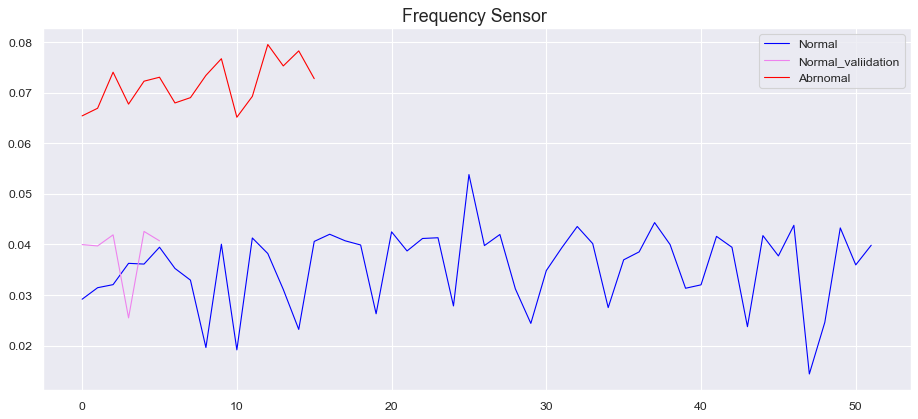

In [17]:
display_data(train_data_0, validation_data_0, test_data_0)

C:\Users\VIP444\Anaconda3\envs\keras\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\VIP444\Anaconda3\envs\keras\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\VIP444\Anaconda3\envs\keras\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


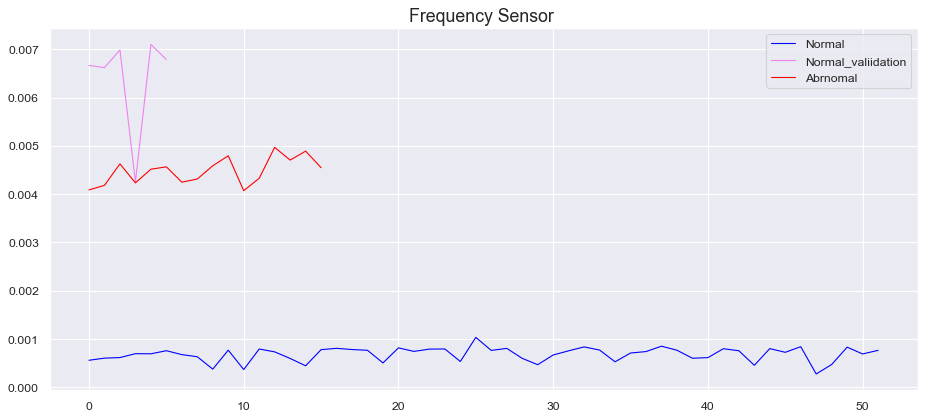

In [5]:
train_data_0_fft, train_data_1_fft, train_data_2_fft, train_data_3_fft = data_to_fft(train_data_0, train_data_1, train_data_2, train_data_3)
validation_data_0_fft, validation_data_1_fft, validation_data_2_fft, validation_data_3_fft = data_to_fft(validation_data_0, validation_data_1, validation_data_2, validation_data_3)
test_data_0_fft, test_data_1_fft, test_data_2_fft, test_data_3_fft = data_to_fft(test_data_0, test_data_1, test_data_2, test_data_3)

display_data(train_data_0_fft, validation_data_0_fft, test_data_0_fft)

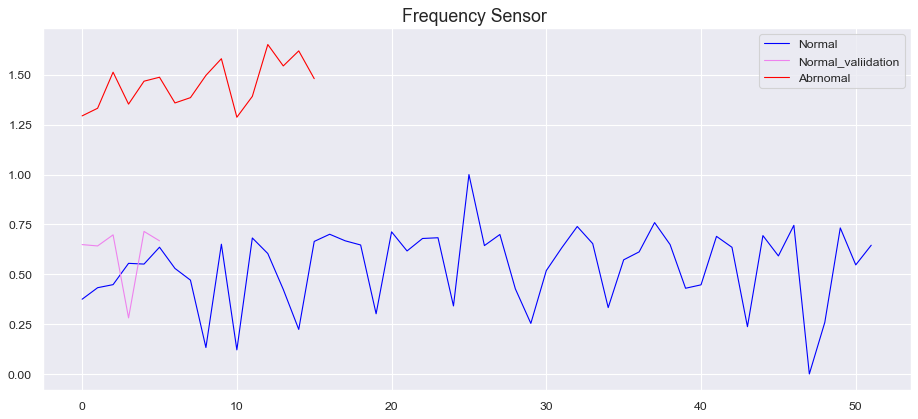

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler = MinMaxScaler()
X_train_0 = data_adjust_scale(scaler, train_data_0, args.data_scale_fit)
X_train_1 = data_adjust_scale(scaler, train_data_1, args.data_scale_trans)
X_train_2 = data_adjust_scale(scaler, train_data_2, args.data_scale_trans)
X_train_3 = data_adjust_scale(scaler, train_data_3, args.data_scale_trans)

X_validation_0 = data_adjust_scale(scaler, validation_data_0, args.data_scale_trans)
X_validation_1 = data_adjust_scale(scaler, validation_data_1, args.data_scale_trans)
X_validation_2 = data_adjust_scale(scaler, validation_data_2, args.data_scale_trans)
X_validation_3 = data_adjust_scale(scaler, validation_data_3, args.data_scale_trans)

X_test_0 = data_adjust_scale(scaler, test_data_0, args.data_scale_trans)
X_test_1 = data_adjust_scale(scaler, test_data_1, args.data_scale_trans)
X_test_2 = data_adjust_scale(scaler, test_data_2, args.data_scale_trans)
X_test_3 = data_adjust_scale(scaler, test_data_3, args.data_scale_trans)

display_data(X_train_0, X_validation_0, X_test_0)

In [ ]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(64, activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(32, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(32, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(64, activation='relu', return_sequences=True)(L4)

    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [5]:
X_train = data_reshape_for_train(X_train_0, X_train_1, X_train_2, X_train_3)
X_validation = data_reshape_for_train(X_validation_0, X_validation_1, X_validation_2, X_validation_3)
X_test = data_reshape_for_train(X_test_0, X_test_1, X_test_2, X_test_3)

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(52, 1, 4)
(6, 1, 4)
(16, 1, 4)


In [ ]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

In [ ]:
nb_epochs = 100
batch_size = 256

checkpoint_path = "model/checkpoint.pt"

callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1), ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)]
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,callbacks=callbacks, validation_split=0.1).history

model.load_weights(checkpoint_path)
model.save("model/model_concate.h5")

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
X_validation = concate_data((X_validation_0, X_validation_1, X_validation_2, X_validation_3), axis=1)
X_validation = X_validation.reshape(X_validation.shape[0], 1, X_validation.shape[1])

X_test = concate_data((X_test_0, X_test_1, X_test_2, X_test_3), axis=1)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

model = tf.keras.models.load_model('model/model_concate.h5')
predictons_3d = model.predict(X_validation)
predictions = predictons_3d.reshape(predictons_3d.shape[0], predictons_3d.shape[2])
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[2])
mse = np.mean(np.power(X_validation - predictions, 2), axis=1)

y_valid = np.ones(len(X_validation))

error_df = pd.DataFrame({'Reconstruction_error':mse, 'True_class': y_valid})

precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

best_cnt_dic = abs(precision_rt - recall_rt)
threshold_fixed = threshold_rt[np.argmin(best_cnt_dic)]

print(precision_rt[np.argmin(best_cnt_dic)])
print(recall_rt[np.argmin(best_cnt_dic)])
print(threshold_fixed)

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
model = tf.keras.models.load_model('model/model_concate.h5')

X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2]) 
X_pred = pd.DataFrame(X_pred)

Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2]) 

scored = pd.DataFrame()
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis=1)
# scored['Loss_mae'] = np.mean(X_pred-Xtrain, axis=1) 

Threshold = 0.017

plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
plt.xlim([0,1])
sns.distplot(scored['Loss_mae'], kde= True, color = 'blue')

In [ ]:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred)

Threshold = 0.3

scored = pd.DataFrame()
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred), axis=1)
scored['Threshold'] = Threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
print(scored)

scored.to_csv('./test_log.csv', sep=',')

In [ ]:
X_validation = X_validation.reshape(X_validation.shape[0], 1, X_validation.shape[1])
X_pred_val = model.predict(X_validation)
X_pred_val = X_pred_val.reshape(X_pred_val.shape[0], X_pred_val.shape[2])
X_pred_val = pd.DataFrame(X_pred_val)

scored_val = pd.DataFrame()
Xvalidation = X_validation.reshape(X_validation.shape[0], X_validation.shape[2])
scored_val['Loss_mae'] = np.mean(np.abs(X_pred_val-Xvalidation), axis=1)
scored_val['Threshold'] = Threshold
scored_val['Anomaly'] = scored_val['Loss_mae'] > scored_val['Threshold']
print(scored_val)
scored_val.to_csv('./validation_log.csv', sep=',')

In [ ]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred)

Threshold = 0.3

scored = pd.DataFrame()
Xtest = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred), axis=1)
scored['Threshold'] = Threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
print(scored)

scored.to_csv('./train_log.csv', sep=',')